In [2]:
import os
os.chdir('/Users/davidf./github_folder/house-prices/')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Feature selection
When talking about machine learning models there will, naturally, always be some features which are more important than others. In order to evaulate the features, lets use a random forest approach and plot the results. 

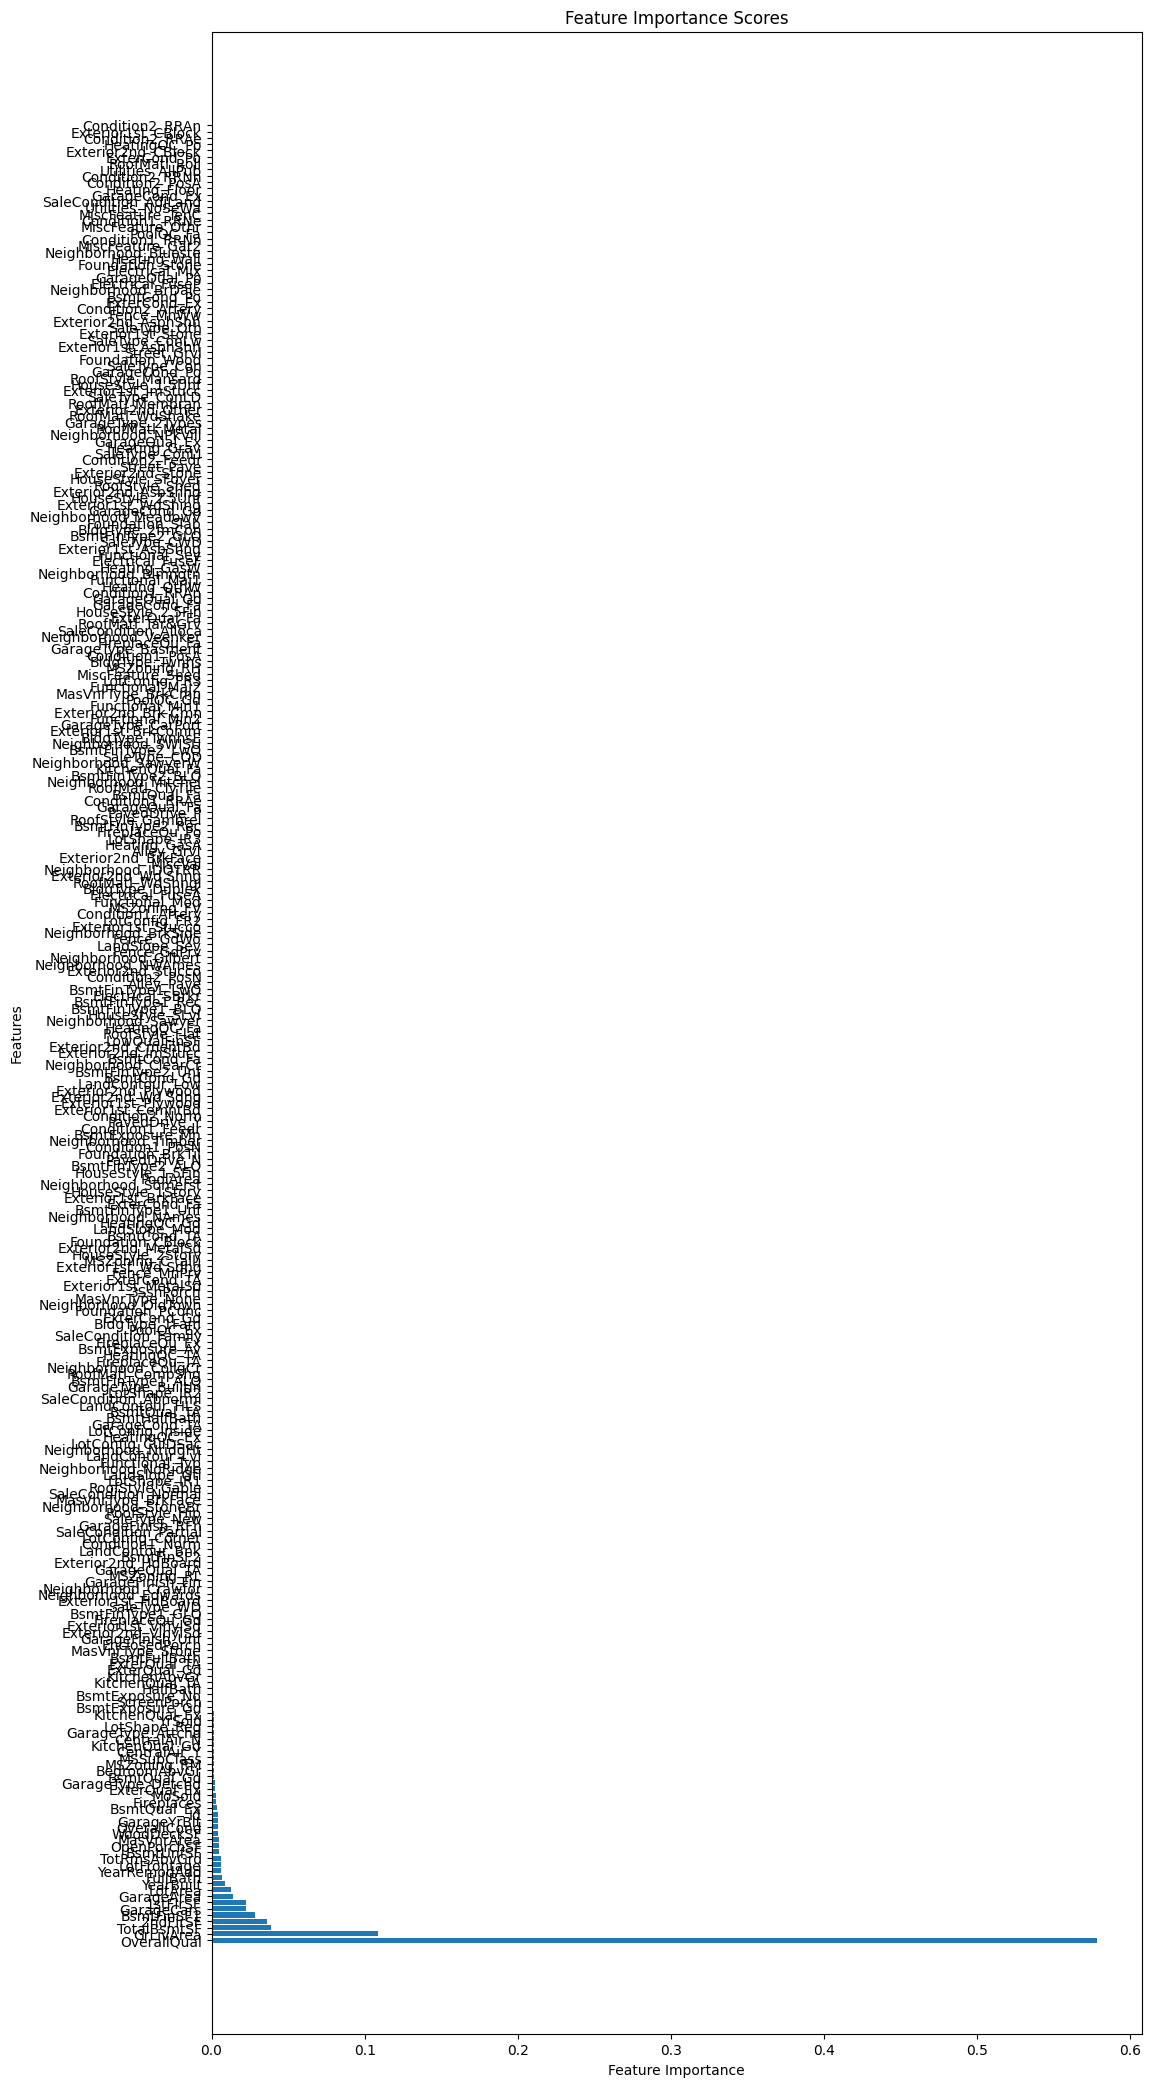

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Load data
data = pd.read_csv('train.csv')

# Split data into features and target
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

# Use one-hot encoding on categorical variables
categorical_cols = X.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Missing values are replaced by the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Use random forest regressor
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_imputed, y)

# Get feature importance scores
importance_scores = rf.feature_importances_

# Sort features
indices = np.argsort(importance_scores)[::-1]
sorted_features = X_encoded.columns[indices]
sorted_scores = importance_scores[indices]

# Plot feature importance
plt.figure(figsize=(12, 26))
plt.barh(range(X_encoded.shape[1]), sorted_scores, align='center')
plt.yticks(range(X_encoded.shape[1]), sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
plt.show()

In [89]:
# Get the 10 most important features
top_10_features = sorted_features[:10]

# Slice the original dataset to include only the top 10 features
X_top_10 = X[top_10_features]
X_top_10

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,GarageCars,1stFlrSF,GarageArea,LotArea,YearBuilt
0,7,1710,856,854,706,2,856,548,8450,2003
1,6,1262,1262,0,978,2,1262,460,9600,1976
2,7,1786,920,866,486,2,920,608,11250,2001
3,7,1717,756,756,216,3,961,642,9550,1915
4,8,2198,1145,1053,655,3,1145,836,14260,2000
...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,694,0,2,953,460,7917,1999
1456,6,2073,1542,0,790,2,2073,500,13175,1978
1457,7,2340,1152,1152,275,1,1188,252,9042,1941
1458,5,1078,1078,0,49,1,1078,240,9717,1950


## Feature importance
The goal of feature selection is to include a sufficient number of features to capture essential data patterns, while avoiding unnecessary complexity that comes with excessive or redundant features, or even features which may impair the model's performance.

A rule of thumb can be to use enough feature to account for 95% of the data. As you can see in the plot, the two most important features account for approx. 55-60% of the data. After the two most important features, the significance of each subsequent feature drops sharply.

XGBoost was used to test the optimal number of features, first using the two most important features, then 7, 10 and finally all the features. For every new model that added features the results were better, which led to all the features being used.

# Hyperparameter tuning with Gridsearch

The final models being used for the task were XGBoost and a Random Forest model. Both models have a number of different hyperparameters, which can be tuned to the task at hand, but finding the optimal hyperparameters can be tricky if done manually. For this reason the gridsearch technique was used to find the optimal hyperparameters for both models.

In [91]:
# Import necessary libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your data
train = pd.read_csv('train.csv')
#test = pd.read_csv('/content/drive/MyDrive/github/housing-price/test.csv')

# Save target variable and ID columns
y = train['SalePrice']
train_id = train['Id']
#test_id = test['Id']

# Drop target variable and 'Id' column from train dataset
train = train.drop(['SalePrice', 'Id'], axis=1)

# Drop 'Id' column from test dataset
#test = test.drop(['Id'], axis=1)

# Define column transformers: separate processes for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, train.select_dtypes(include=np.number).columns),
        ('cat', categorical_transformer, train.select_dtypes(include='object').columns)
    ])

# Append classifier to preprocessing pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBRegressor())  # Use 'gpu_hist' to utilize GPU
])

# Define a hyperparameter grid to search over
param_grid = {
    'classifier__n_estimators': [500],
    'classifier__learning_rate': [0.06],
    'classifier__max_depth': [4],
    'classifier__colsample_bytree': [.2],
    'classifier__gamma': [0],
    'classifier__alpha': [0.95, 1, 1.05],  # L1 regularization terms
    'classifier__lambda': [0.95, 1, 1.05]  # L2 regularization terms
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Split your data into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=0)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__alpha': 0.95, 'classifier__colsample_bytree': 0.2, 'classifier__gamma': 0, 'classifier__lambda': 0.95, 'classifier__learning_rate': 0.06, 'classifier__max_depth': 4, 'classifier__n_estimators': 500}
-728822385.7065674


# Final model

The initial step is data preprocessing, which includes imputing missing values and standardizing numerical attributes. The data preprocessing enhances data uniformity, which makes it easier for the models to learn. The rules established by the preprocessing are subsequently implemented through the 'fit_transform' method.

Two machine learning models are then initiated, one using XGBoost and the other using Random Forest. The results of these models are then assessed via a stacking model, employing linear regression to draw a final prediction from their outputs.

To evaluate model performance and enhance their robustness, cross-validation is used.

In the final stage, the models are used to make predictions on the test data. The resulting predictions are saved in a CSV file.

At time of writing, the results of the model ensure a 1,031 place on Kaggle.


In [68]:
# Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Define preprocessor
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice')
categorical_features = train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Subset features and target variable
X_train = train.drop(['SalePrice'], axis=1)
y_train = train['SalePrice']

# Fit transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Define models
model_xgb = XGBRegressor(alpha=1, colsample_bytree=0.2, gamma=0, reg_lambda=1, learning_rate=0.06, max_depth=4, 
                     n_estimators=500, random_state=42, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

model_rf = RandomForestRegressor(n_estimators=640,max_depth=30, min_samples_leaf= 1, min_samples_split=8, random_state=1)

# Create meta model
meta_model = LinearRegression()

# Create the stacking model
stacking_model = StackingRegressor(estimators=[('xgb', model_xgb), ('rf', model_rf)], final_estimator=meta_model)

# Start cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Perform cross validation
scores = cross_val_score(stacking_model, X_train_preprocessed, y_train, cv=kfold, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-scores.mean():.2f} ± {scores.std():.2f}")

# Use the stacking model on the whole training dataset
stacking_model.fit(X_train_preprocessed, y_train)

# Transform the test dataset
X_test_preprocessed = preprocessor.transform(test)

# Use model to make predictions
predictions = stacking_model.predict(X_test_preprocessed)

# Save predictions to csv
df_kaggle = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
df_kaggle.to_csv('submission.csv', index=False)